# Essentiality analysis

The goal of this analysis is to ensure the model correctly predicts the presence or absence of cell growth for well known mutants. Unlike for _E. coli_, extensive mutant libraries have not been charcterized for C. therm. Rather, a few mutants of biotechnological relevance have been relatively well studied.

## Background

### HydG-ech derived mutants

The standard for GEM model validation is the prediction of essentiality phenotypes. In particular, those relevant to metabolic engineering of C. thermocellum should be predicted accurately. To prevent designs which grow in-silico but are lethal in vivo.

In the publication 
> Thompson, R. Adam, et al. "Elucidating central metabolic redox obstacles hindering ethanol production in Clostridium thermocellum." Metabolic engineering 32 (2015): 207-219."

different lethal phenotypes captured by a core model are presented. The experimental evidence is provided in the figure below.

Fig. 5. Growth characteristics of parent strain (triangles) and ΔhydG Δech (circles) in MTC media (filled symbols) or MTC with the PFL inhibitor hypophosphite (open symbols). To investigate redox bottlenecks, no additional electron sink (A), 20 mM fumarate (B), 20 mM 2-ketoisovalerate (C), or 2 g/L total sulfate (D) were included in the medium to probe NADH, NAD(P)H, and Fdrd, respectively.

<img src="fig5_thompson2015.jpg" alt="Drawing" style="width: 100px;"/>

Based on this evidence, the following phenotypes should be captured by the model:
1. hydG-ech-pfl deletion is lethal
2. hydG-ech-pfl deletion can recover growth in the presence of an external electron sink, either sulfate or kiv.

The most important being phenotype 1.

## LL1210 related mutants
The publication 
> Tian, Liang, et al. "Simultaneous achievement of high ethanol yield and titer in Clostridium thermocellum." Biotechnology for biofuels 9.1 (2016): 116.

studies the mutant with deletion of hydG, ldh, pfl, pta-ackA

| Strain name | Description                                                | Growth rate μ (h−1) |
|-------------|------------------------------------------------------------|---------------------|
| AG553       | C. thermocellum DSM1313 Δhpt ΔhydG Δldh Δpfl Δpta-ack [10] | 0.06 ± 0.01         |
| AG601       | Selected from AG553 after first stage adaptive evolution   | 0.10 ± 0.01         |
| LL1210      | Selected from AG601 after second stage adaptive evolution  | 0.22 ± 0.02         |

As a reference a wild type in avicell tubes grows at 0.33-0.39 (h-1) (see extracelular flux table). While it is not crucial to capture the quantitative change in growth rate it is imporant to ensure that:
3. hydg-ldh-pfl-pta/ack mutant can grow

# Model simulations

In [1]:
%matplotlib inline
import os
import sys
sys.path.append('/home/sergio/Dropbox/cthermgem-dev')
os.chdir('/home/sergio/Dropbox/cthermgem-dev')
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import csv

import numpy as np
import tools.conf_model
import cobra as cb
import settings
from tools.essentiality import *
model = cb.io.load_json_model(os.path.join(settings.INTERMEDIATE_MODEL_ROOT, 'iSG_5.json'))
set_conditions(model, medium_str='cellb', secretion='common_secretion')
model.objective = 'BIOMASS_CELLOBIOSE'

#Several features were updated after this notebook, thus to make the code reproducible, this features must be reverted to their original state:
model.reactions.EX_h2s_e.bounds = (0,1000) # Enable sulfide secretion
model.reactions.ACS.bounds = (0,1000) # Enable ACS

## Phenotype 1: hydG-ech-pfl mutant cannot growth in minimal medium

In [2]:
r_wt = model.optimize()
print('Growth rate of wt: {:.2f}'.format(r_wt.objective_value))

mut_ko = ['BIF','H2ASE_syn', 'PFL', 'ECH']
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko]
    r = tmodel.optimize()
    print('Growth rate of hydG-ech-pfl ko: {:.2f} \t fraction of wt: {:.2f}'.format(r.objective_value, r.objective_value/r_wt.objective_value))    
    tmodel.summary()

Growth rate of wt: 0.38
Growth rate of hydG-ech-pfl ko: 0.19 	 fraction of wt: 0.50
IN FLUXES          OUT FLUXES         OBJECTIVES
-----------------  -----------------  ----------------------
cellb_e  4         lac__L_e  8.16     BIOMASS_CELL...  0.188
so4_e    1.94      h_e       7.46
nh4_e    1.41      h2o_e     6.92
pi_e     0.203     co2_e     5.98
k_e      0.179     etoh_e    5.42
mg2_e    0.0258    h2s_e     1.92
fe3_e    0.000874  phe__L_e  0.0448
ca2_e    0.000813  gly_e     0.00755


The growth rate of this mutant is 50% that of the wild type. GEMs are known to overpredict growth since they do not account for important kinetic and regulatory limiations. However, lethality is often consired around a reduction of 80-90% of the theoretical maximum. Using that reference, we can say that __the model is failing to predict the lethality phenotype.__

We observe sulfide secretion, this pathway was studied by Thompson 2015 and further analyzed by [Biswas 2017]( https://biotechnologyforbiofuels.biomedcentral.com/articles/10.1186/s13068-016-0684-x). Biswas 2017 observed a range of 10-20 umol depending on the mutant. 
    

In [3]:
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko]
    tmodel.reactions.EX_h2s_e.knock_out()
    rmut = tmodel.optimize()
    tmodel.summary()

with model as tmodel:
    tmodel.reactions.EX_h2s_e.knock_out()
    r = tmodel.optimize()
    print('WT-EX_h2s_e gr: {:.2f}'.format(r.objective_value))

print('Fraction of wt growth: {:.2f}'.format(rmut.objective_value/r.objective_value))

deleted_rxns = ['EX_h2s_e']

IN FLUXES          OUT FLUXES          OBJECTIVES
-----------------  ------------------  ----------------------
cellb_e  4         h_e       15        BIOMASS_CELL...  0.158
h2o_e    1.27      lac__L_e  14
nh4_e    1.19      co2_e      0.473
pi_e     0.17      phe__L_e   0.0375
k_e      0.15      gly_e      0.00633
mg2_e    0.0216
so4_e    0.0204
fe3_e    0.000733
ca2_e    0.000682
WT-EX_h2s_e gr: 0.38
Fraction of wt growth: 0.42


The elimination of sulfide secretion continues to reduce growth rate of the mutant to 42% of the wild type.

The current understanding of this mutant is that POR cannot produce suficcient acetyl-coa for growth due to the accumulation of reduced ferredoxin. This opens two hypothesis that still explain growth:
1. An alternative source of Acetyl-CoA is active.
2. An alternative ferredoxin (or indirectly nad(p)h) oxidation pathway is active.

In [4]:
# Sources of accoa
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko]
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    tmodel.metabolites.accoa_c.summary()
    tmodel.reactions.ACS.knock_out()
    rmut = tmodel.optimize()
    tmodel.summary()
    tmodel.metabolites.accoa_c.summary()

with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    tmodel.reactions.ACS.knock_out()
    r = tmodel.optimize()

print('\nWT-EX_h2s_e gr: {:.2f}'.format(r.objective_value))
mut_gr = rmut.objective_value
print('Fraction of wt growth: {:.2f}'.format(mut_gr/r.objective_value))

deleted_rxns.append('ACS')

PRODUCING REACTIONS -- Acetyl-CoA (accoa_c)
-------------------------------------------
%       FLUX  RXN ID    REACTION
---  -------  --------  --------------------------------------------------
97%  14.1     ACS       ac_c + atp_c + coa_c --> accoa_c + amp_c + ppi_c
3%    0.436   POR       coa_c + 2.0 fdxo_42_c + pyr_c --> accoa_c + co2...

CONSUMING REACTIONS -- Acetyl-CoA (accoa_c)
-------------------------------------------
%       FLUX  RXN ID    REACTION
---  -------  --------  --------------------------------------------------
97%  14.1     PTAr      accoa_c + pi_c <=> actp_c + coa_c
1%    0.198   ACCOAC    accoa_c + atp_c + co2_c + h2o_c --> adp_c + 2.0...
1%    0.114   CS        accoa_c + h2o_c + oaa_c --> cit_c + coa_c + h_c
0%    0.0609  HSERTA    accoa_c + hom__L_c <=> achms_c + coa_c
0%    0.0527  IPPS      3mob_c + accoa_c + h2o_c --> 3c3hmp_c + coa_c +...
0%    0.0452  G1PACT    accoa_c + gam1p_c --> acgam1p_c + coa_c + h_c
0%    0.0252  ACOATA    ACP_c + accoa_c --> ac

We observed that ACS was capable of generating the majority of acetyl CoA required for growth. ACS was added to the model due to the genome annotation but there is no evidence of this reaction in C. therm. Furhtermore acetate consumption phenotypes have not been observed. So the current knowledge leads us to believe that ACS is not active in C. therm.

These modifications reduce growth to 20% of the wild type. This can be considered lethal, even for more curated models. We will dig a bit further to identify what pathways still support growth.

Investigating potential errors in redox metabolism is much more challenging since due to its highly redundant and interconected nature, as well as interactions with major metabolic reactions which cannot be deleted. Thus, we will perform a systematic deletion analysis to identify which single-deletions reduce growth rate below 20% of the wild type value

In [5]:
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    # wt
    r_wt = tmodel.optimize()
    wt_del = cb.flux_analysis.single_reaction_deletion(tmodel)
    
    # mut
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko]
    mut_del = cb.flux_analysis.single_reaction_deletion(tmodel)

MIN_GROWTH = 0.2* r_wt.objective_value
mut_essen = set(mut_del.index[mut_del['growth']<= MIN_GROWTH])
wt_essen = set(wt_del.index[wt_del['growth']<= MIN_GROWTH])
wt_eff = set(wt_del.index[wt_del['growth'] < 0.9*r_wt.objective_value]) # deletions which reduce wt growth below 90% of the original value

print('Essential in: WT: {}; Mut: {}, Mutant and not WT (excluding reactions which reduce wt growth below 90%): {}\n'.format(len(wt_essen), len(mut_essen), len((mut_essen-wt_essen)-wt_eff)))
keyrxn = mut_essen-wt_essen-wt_eff
for rxn in keyrxn:
    rxnid = list(rxn)[0]
    print('{} \t {}'.format(list(rxn)[0], model.reactions.get_by_id(rxnid).reaction))

Essential in: WT: 210; Mut: 225, Mutant and not WT (excluding reactions which reduce wt growth below 90%): 16

DRPA 	 2dr5p_c --> acald_c + g3p_c
GLYt2r 	 gly_c + h_c <=> gly_e + h_e
POR 	 coa_c + 2.0 fdxo_42_c + pyr_c --> accoa_c + co2_c + 2.0 fdxr_42_c + h_c
GLUDy 	 glu__L_c + h2o_c + nadp_c <=> akg_c + h_c + nadph_c + nh4_c
ALCD2x 	 acald_c + h_c + nadh_c --> etoh_c + nad_c
PPM2 	 2dr1p_c <=> 2dr5p_c
MTHFC 	 h2o_c + methf_c <=> 10fthf_c
EX_etoh_e 	 etoh_e --> 
PPDK 	 amp_c + h_c + pep_c + ppi_c --> atp_c + pi_c + pyr_c
VALt2r 	 h_c + val__L_c <=> h_e + val__L_e
EX_gly_e 	 gly_e --> 
NDPK1 	 atp_c + gdp_c <=> adp_c + gtp_c
ETOHt 	 etoh_c <=> etoh_e
FRNDPR2r 	 2.0 fdxr_42_c + h_c + nadh_c + 2.0 nadp_c <=> 2.0 fdxo_42_c + nad_c + 2.0 nadph_c
ATPS 	 atp_c + h2o_c + h_c --> adp_c + 2.0 h_e + pi_c
EX_val__L_e 	 val__L_e --> 


Several electron sinks suport growth. Notably MTHFC deletion makes PFL essential. 

## Conclusion for Phenotype 1
1. ACS was providing an acetyl-CoA source which is likely not present or relevant in C. therm. There is no evidence of this reaction in C. therm. 
2. Sulfide secretion provided an electron sink. When high amounts of sulfate are provided to the medium, growth is observed. Otherwise we consider this pathway to not be relevant, and thus remove sulfide secretion.
Modification of these two features reduces growth rate to 20% of the wild type maximum, which is considered lethal. 

# Phenotype 2: Do fumarate, sulfate, or ketoisovalerate recover growth in the mutant?

In the Core model publication cited at the begining, the addition of the following reactions in separate instances led the model to precit growth:

| ID    | Formula                                               | Genes             |
|-------|-------------------------------------------------------|-------------------|
| FUM1  | FUM_ext = FUM .                                       |                   |
| FUM2  | FUM + NADH = SUCC + NAD .                             | Clo1313_2640;3018 |
| FUM3  | SUCC = SUCC_ext.                                      |                   |
| ISOV1 | AKIV_ext = AKIV .                                     |                   |
| ISOV2 | AKIV + fdox + 2 NADPH = IBOH + CO2 + fdred + 2 NADP . | Clo1313_0382-383  |
| ISOV3 | IBOH = IBOH_ext .                                     |                   |
| SULF1 | SO4_ext = SO4 .                                       |                   |
| SULF2 | SO4 + fdred = SO3 + fdox .                            | Clo1313_0118-124  |
| SULF3 | SO3 + fdred = Sulfide + fdox .                        | Clo1313_0118-124  |
| SULF4 | Sulfide = Sulf_ext .                                  |                   |

As previously noted, only sulfate and kivd addition recover growth (albeit not as in the wild type, but rather with low growth or long lag phase)


## Fumarate


In [6]:
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko]

    # allow fumarate input
    tmodel.reactions.EX_fum_e.bounds = (-1000,0)
    # Include reaction converting fumarate to succinate, which is not present in the GEM
    FUM2 = cb.Reaction(id='FUM2')
    tmodel.add_reaction(FUM2)
    tmodel.reactions.FUM2.reaction = 'fum_c + nadh_c + h_c => succ_c + nad_c'
    # allow succinate secretion
    tmodel.reactions.EX_succ_e.bounds = (0,1000)
    # tmodel.objective = 'FUM2' # check the reaction is not blocked
    r = tmodel.optimize()
    tmodel.summary()
    mut_fum_gr = r.objective_value

IN FLUXES           OUT FLUXES         OBJECTIVES
------------------  -----------------  ----------------------
fum_e    128        succ_e    105      BIOMASS_CELL...  0.598
h2o_e     48.5      co2_e      56.6
h_e       11.1      ac_e       31.6
nh4_e      4.49     phe__L_e    0.142
cellb_e    4        gly_e       0.024
pi_e       0.645
k_e        0.569
mg2_e      0.082
so4_e      0.0773
fe3_e      0.00278
ca2_e      0.00258


Fumarate predicts growth recovery consistently with the redox-imbalance hypothesis

## Sulfate
Sulfate is essential for the model, since it is used to provide sulfur for cysteine biosynthesis, as demonstrated by the plot below. 
However, we can simulate high concentrations of sulfate by enabling h2s secretion.

(0, 1000)


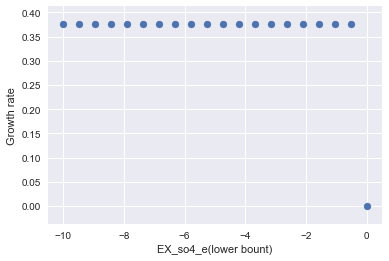

In [7]:
x = np.linspace(-10,0,20)
y = []
with model:
    for l in np.nditer(x):
        model.reactions.EX_so4_e.lower_bound = l
        y.append(model.optimize().objective_value)
plt.scatter(x,y)
plt.xlabel('EX_so4_e(lower bount)')
plt.ylabel('Growth rate')
print(model.reactions.EX_h2s_e.bounds)

In [8]:
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko]

    # allow sulfide secretion
    tmodel.reactions.EX_h2s_e.bounds = (0,1000)

    # tmodel.objective = 'FUM2' # check the reaction is not blocked
    mut_sul_gr = tmodel.optimize().objective_value
    tmodel.summary()

IN FLUXES          OUT FLUXES         OBJECTIVES
-----------------  -----------------  ----------------------
cellb_e  4         lac__L_e  8.19     BIOMASS_CELL...  0.188
so4_e    1.98      h_e       7.53
nh4_e    1.41      h2o_e     6.98
pi_e     0.203     co2_e     5.96
k_e      0.179     etoh_e    5.31
mg2_e    0.0258    h2s_e     1.95
fe3_e    0.000873  ac_e      0.0802
ca2_e    0.000812  phe__L_e  0.0447
                   gly_e     0.00753


Indeed so4 uptake is significantly increased, and a significant efflux of h2s enables growth.

## KIV

Here we enable the isobutanol pathway providing one of its intermediates

In [9]:
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko]
    tmodel.reactions.EX_ibutoh_e.bounds = (0,1000)
    sk = tmodel.add_boundary(tmodel.metabolites.get_by_id('3mob_c'))
    mut_kiv_gr = tmodel.optimize().objective_value
    tmodel.summary()

IN FLUXES          OUT FLUXES         OBJECTIVES
-----------------  -----------------  ---------------------
3mob_c   34.9      co2_e     47.4     BIOMASS_CELL...  0.38
h_e      21        ibutoh_e  34.7
h2o_e     9.44     ac_e      11.5
cellb_e   4        phe__L_e   0.0902
nh4_e     2.85     gly_e      0.0152
pi_e      0.409
k_e       0.361
mg2_e     0.052
so4_e     0.049
fe3_e     0.00176
ca2_e     0.00164


Again this fully recovers growth. Unlike fumarate, growth rate goes back to the wild-type level. 

## Conclusion for phenotype 2:
The predictions are consistent with the core model, which accuratly represented experimental observations with the exception of fumarate. 

## Phenotype 3: Growth of LL1210

As shown below the strain is able to grow, consistently with experimental observations.

In [10]:
# ll1210 mutant
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    r_wt = model.optimize()
    wt_gr = r_wt.objective_value
    tmodel.reactions.BIF.knock_out() #hydg
    tmodel.reactions.H2ASE_syn.knock_out() #hydg
    tmodel.reactions.PFL.knock_out()
    tmodel.reactions.LDH_L.knock_out()
    tmodel.reactions.PTAr.knock_out()
    tmodel.reactions.ACKr.knock_out()
    
    r = tmodel.optimize()
    ll1210_gr = r.objective_value
    tmodel.summary()
    print('Growth rate of wt: {:.2f}, growth rate of Mut: {:.2f}, fraction: {:.2f}'.format(
        r_wt.objective_value, r.objective_value, r.objective_value/r_wt.objective_value))

    

IN FLUXES         OUT FLUXES         OBJECTIVES
----------------  -----------------  ----------------------
cellb_e  4        h2_e      13.7     BIOMASS_CELL...  0.295
h2o_e    2.97     co2_e     13.3
nh4_e    2.22     etoh_e     8.3
pi_e     0.318    h_e        5.73
k_e      0.281    ac_e       3.82
mg2_e    0.0405   phe__L_e   0.0702
so4_e    0.0381   gly_e      0.0118
fe3_e    0.00137
ca2_e    0.00127
Growth rate of wt: 0.38, growth rate of Mut: 0.30, fraction: 0.79


## Fractions of growth reduction for different mutants/strains

In [11]:
## Add other mutants:
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    tmodel.reactions.BIF.knock_out() #hydg
    tmodel.reactions.H2ASE_syn.knock_out() #hydg 
    hydg_gr = tmodel.optimize().objective_value
    tmodel.reactions.ECH.knock_out()
    hydgech_gr = tmodel.optimize().objective_value

with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    tmodel.reactions.BIF.knock_out() #hydg
    tmodel.reactions.H2ASE_syn.knock_out() #hydg 
    tmodel.reactions.PTAr.knock_out()
    tmodel.reactions.ACKr.knock_out()
    hydgpta_gr = tmodel.optimize().objective_value

with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    tmodel.reactions.LDH_L.knock_out()
    ldh_gr = tmodel.optimize().objective_value
    tmodel.reactions.PTAr.knock_out()
    tmodel.reactions.ACKr.knock_out()
    ldhpta_gr = tmodel.optimize().objective_value

with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    tmodel.reactions.PTAr.knock_out()
    tmodel.reactions.ACKr.knock_out()
    pta_gr = tmodel.optimize().objective_value


with open('mutant_gr.csv', 'w') as f:
    w = csv.writer(f, delimiter=',', lineterminator='\n')
    mut = 'hydG-ech-pfl'
    ll1210 = 'hydG-pfl-ldh-pta-ack'
    w.writerow(['Strain', 'Medium', 'Fraction of WT growth rate'])
    w.writerow(['hydG','MTC',hydg_gr/wt_gr])
    w.writerow(['hydG-ech','MTC',hydg_gr/wt_gr])
    w.writerow(['hydG-ech-pta-ack','MTC', hydgpta_gr/wt_gr])
    w.writerow([mut,'MTC', mut_gr/wt_gr])
    w.writerow([mut,'MTC+fumarate', mut_fum_gr/wt_gr])
    w.writerow([mut,'MTC+sulfate', mut_sul_gr/wt_gr])
    w.writerow([mut,'MTC+ketoisovalerate', mut_kiv_gr/wt_gr])
    w.writerow([ll1210, 'MTC', ll1210_gr/wt_gr])
    w.writerow(['ldh', 'MTC', ldh_gr/wt_gr])
    w.writerow(['pta-ack','MTC',pta_gr/wt_gr])
    w.writerow(['ldh-pta-ack','MTC',ldhpta_gr/wt_gr])

In [12]:
# pta-ack can still make significant ammounts of acetate in-silico:
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    tmodel.reactions.LDH_L.knock_out()
    tmodel.reactions.PTAr.knock_out()
    tmodel.reactions.ACKr.knock_out()
    tmodel.optimize()
    tmodel.summary()
    tmodel.metabolites.ac_c.summary()

IN FLUXES         OUT FLUXES         OBJECTIVES
----------------  -----------------  ----------------------
h2o_e    9.24     h_e       13.6     BIOMASS_CELL...  0.364
cellb_e  4        co2_e     12.6
nh4_e    2.72     ac_e      11.2
pi_e     0.392    phe__L_e   0.0865
k_e      0.346
mg2_e    0.0499
so4_e    0.047
fe3_e    0.00169
ca2_e    0.00157
PRODUCING REACTIONS -- Acetate (ac_c)
-------------------------------------
%        FLUX  RXN ID    REACTION
----  -------  --------  --------------------------------------------------
89%    9.97    ACADT     acad_c + ppi_c --> ac_c + atp_c + h_c
11%    1.21    ALDD2y    acald_c + h2o_c + nadp_c --> ac_c + 2.0 h_c + n...
0%     0.0321  AHHST     achms_c + h2s_c --> ac_c + hcys__L_c
0%     0.015   CYSS      acser_c + h2s_c --> ac_c + cys__L_c

CONSUMING REACTIONS -- Acetate (ac_c)
-------------------------------------
%        FLUX  RXN ID    REACTION
----  -------  --------  --------------------------------------------------
100%  11.2     